# CS 584 Assignment 4 -- Sequence to Sequence Models

#### Name: Chopra, Agamdeep

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement a Seq2Seq model.

*** Please note that there are many online resources for Seq2Seq models, you are allowed to check them, but DO NOT DIRECTLY COPY from them. Otherwise, you will get ZERO for this assignment. ***

In [1]:
!pip install numpy scikit-learn tqdm matplotlib
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [2]:
!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio===0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [3]:
!pip3 install nltk

## 1. Data Process
In this section, you are required to 
1. Divide the data into train, validation, and test.
2. Preprocess the text data

**Note:** The default dataset is for Spanish-English. Feel free to change other pairs of languages, you can find them [here](http://www.statmt.org/europarl/).

In [4]:
import numpy as np
#from tqdm.notebook import tqdm

def load_data(filepath):
    texts = []
    with open(filepath, 'r', encoding='utf-8') as f:
        count = len(f.readlines())
        
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            texts.append(line.strip())
            
    return np.array(texts[:20000])

sources = load_data('R:\classes 2020-22\Fall 2021\CS 584 NLP\HW4\content\en.txt')
targets = load_data('R:\classes 2020-22\Fall 2021\CS 584 NLP\HW4\content\es.txt')

print('Englist sentences size:', sources.shape)
print('Spanish sentences size:', targets.shape)

Englist sentences size: (20000,)
Spanish sentences size: (20000,)


### 1.1 Divide the data into train, validation, and test

In [5]:
from sklearn.model_selection import train_test_split

source_train, source_test, target_train, target_test = train_test_split(sources, targets, test_size=0.2)
source_train, source_valid, target_train, target_valid = train_test_split(source_train, target_train, test_size=0.2)

train_texts = [(sent_source, sent_target) for sent_source, sent_target in zip(source_train, target_train)]
valid_texts = [(sent_source, sent_target) for sent_source, sent_target in zip(source_valid, target_valid)]
test_texts = [(sent_source, sent_target) for sent_source, sent_target in zip(source_test, target_test)]

print('The size of training set:', len(train_texts))
print('The size of valid set:', len(valid_texts))
print('The size of test set:', len(test_texts))

The size of training set: 12800
The size of valid set: 3200
The size of test set: 4000


### 1.2 Data preprocessing
1. Lowercase the text
2. Tokenize the text
3. Create vocabulary for the source language and target language, respectively.

In [6]:
import re
import string
import spacy
from itertools import chain
from unicodedata import normalize, category

nlp_en = spacy.load('en_core_web_sm')
nlp_es = spacy.load('es_core_news_sm')


def tokenize_en(text):
    doc = nlp_en(text.lower())
    return [token.text for token in doc]

def tokenize_es(text):
    doc = nlp_es(text.lower())
    return [token.text for token in doc]

def preprocess(texts, type='en'):
    if type == 'en':
        return [tokenize_en(text) for text in texts]
    elif type == 'es':
        return [tokenize_es(text) for text in texts]

def generate_vocab(tokenized_texts):
    # Flatten the input to 1d array, Thanks for: 
    # https://stackoverflow.com/questions/29244286/how-to-flatten-a-2d-list-to-1d-without-using-numpy
    vocab = list(chain.from_iterable(tokenized_texts))
    return list(set(vocab))

source_tokens = preprocess(source_train, 'en')
target_tokens = preprocess(target_train, 'es')

source_vocab = generate_vocab(source_tokens)
source_vocab.insert(0, '<unk>')
source_token2idx = {token: idx for idx, token in enumerate(source_vocab)}

target_vocab = generate_vocab(target_tokens)
target_vocab.insert(0, '<end>')
target_vocab.insert(0, '<start>')
target_vocab.insert(0, '<unk>')
target_token2idx = {token: idx for idx, token in enumerate(target_vocab)}

print('English vocab size:', len(source_vocab))
print('Spanish vocab size:', len(target_vocab))

English vocab size: 12577
Spanish vocab size: 19883


In [7]:
train_set = [([source_token2idx[t] for t in tokenize_en(source)], [target_token2idx[t] for t in tokenize_es(target)]) for source, target in train_texts]
valid_set = [([source_token2idx[t] if t in source_token2idx else 0 for t in tokenize_en(source)], [target_token2idx[t] if t in target_token2idx else 0 for t in tokenize_es(target)]) for source, target in valid_texts]
test_set = [([source_token2idx[t] if t in source_token2idx else 0 for t in tokenize_en(source)], [target_token2idx[t] if t in target_token2idx else 0 for t in tokenize_es(target)]) for source, target in test_texts]


In [8]:
print(target_vocab.index('<start>'))
print(target_vocab.index('<end>'))
print(target_vocab.index('<unk>'))

1
2
0


## 2. Seq2Seq Model (50 points)
In this section, you are required to 
1. Implement a seq2seq model which includes a CNN encoder and an RNN based decoder.  
2. For each RNN cell, try a simple RNN, LSTM, and GRU.  
3. Use the validation set to compute the BLEU score and report the best choice.

**Note:** you could use any package you are comfortable with, such as PyTorch and TensorFlow.

### 2.1 Encoder (25 points)

Try a simple RNN, LSTM, and GRU

In [76]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print('active device =', device)

class Encoder(nn.Module):

    def __init__(self, vocab_size=None, embedding_size=None, cell_type = 'GRU', hidden_size=50, layers = 3, device=device):
        super(Encoder, self).__init__()
        self.cell_type = cell_type
        self.layers = layers
        self.vocab_size = vocab_size
        self.device = device
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size).to(device)
        if cell_type == 'RNN':
            self.cell = nn.RNN(embedding_size, hidden_size, batch_first=True, num_layers=layers).to(device)
        elif cell_type == 'LSTM':
            self.cell = nn.LSTM(embedding_size, hidden_size, batch_first=True, num_layers=layers).to(device)
        else:
            self.cell = nn.GRU(embedding_size, hidden_size, batch_first=True, num_layers=layers).to(device)

    def forward(self, x, hidden):
        if hidden == None:
            if self.cell_type != 'LSTM':
                hidden = torch.zeros(self.layers, x.shape[0], self.hidden_size).to(self.device)
                #print('encoder, h0 shape-', hidden.shape)
            else:
                hidden = (torch.zeros(self.layers, x.shape[0], self.hidden_size).to(self.device), torch.zeros(self.layers, x.shape[0], self.hidden_size).to(self.device))
                #print('encoder, h0 shape-', hidden[0].shape,'cell_state0-', hidden[1].shape)
        '''
        else: 
            try:
                print('encoder, hn shape-', hidden.shape)
            except:
                print('encoder, hn shape-', hidden[0].shape,'cell_staten-', hidden[1].shape)
        '''
        #print(x.shape)
        if(x<self.vocab_size):
            x=OneHot(x.unsqueeze(0),self.vocab_size).squeeze()
            #print(x.shape)
            embedded = self.embedding(x.to(self.device, dtype = torch.int))
            #print('normal x, encoder')
        else:
            embedded = self.embedding(OneHot(torch.zeros((1,1,1)),source_vocab).squeeze().to(self.device, dtype = torch.int))
            #print('setting <unk> (1,1) x, encoder')
        #print(embedded.shape)
        #print(embedded.shape)
        embedded = embedded.unsqueeze(0)
        #print(embedded.shape)
        try:
            _, hidden = self.cell(embedded, hidden.to(device))
        except:
            _, hidden = self.cell(embedded, (hidden[0].to(device),hidden[1].to(device)))
        #print(hidden.shape)
        return hidden

active device = cuda


### 2.2 CNN Encoder (Extra Credit)

A traditional encoder of Seq2Seq models is an RNN-based model, such as RNN, LSTM, or GRU. But CNNs can also be encoders. In this sub-section, you need to implement a CNN encoder for your Seq2Seq model.

**Hint:** We already learned how CNN can be applied to sentence classification tasks. You can simply drop the last layer of TextCNN and output the context vector. Please check this [paper](https://arxiv.org/abs/1510.03820) for details.

In [77]:
class CNN_Encoder(nn.Module):

    def __init__(self, vocab_size=None, embedding_size=None, n_f = 100, kernel = [3,4,5], device=device):
        super(CNN_Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.device = device
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size, embedding_size).to(device)
        self.cell = nn.ModuleList([nn.Conv2d(1, n_f, (k,embedding_size)) for k in kernel]).to(device)
        self.relu = nn.ReLU()

    def forward(self, x):
        embedded = self.embedding(x.to(self.device)).unsqueeze(1)
        h = [self.relu(cell(embedded)).squeeze(3) for cell in self.cell] 
        h = [torch.nn.functional.max_pool1d(vect, vect.shape[2]).squeeze(2) for vect in h]  
        return h

### 2.3 Decoder (25 points)
Try a simple RNN, LSTM, and GRU

In [78]:
class Decoder(nn.Module):

    def __init__(self, vocab_size=None, embedding_size=None, cell_type = 'GRU', hidden_size=50, layers = 3, device=device):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.device = device
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size).to(device)
        if cell_type == 'RNN':
            self.cell = nn.RNN(embedding_size, hidden_size, batch_first=True, num_layers=layers).to(device)
        elif cell_type == 'LSTM':
            self.cell = nn.LSTM(embedding_size, hidden_size, batch_first=True, num_layers=layers).to(device)
        else:
            self.cell = nn.GRU(embedding_size, hidden_size, batch_first=True, num_layers=layers).to(device)
        self.fc = nn.Linear(hidden_size, vocab_size).to(device)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        #x = x.unsqueeze(1)
        #print(x.shape)
        x = self.relu(x.to(device,dtype = torch.int))
        embedded = self.embedding(x)
        #print(embedded.shape, hidden.shape)
        try:
            output, hidden = self.cell(embedded, hidden.to(device))
        except:
            output, hidden = self.cell(embedded, (hidden[0].to(device),hidden[1].to(device)))
        #print(output.shape, hidden.shape)
        output = output.squeeze(1)
        output = self.fc(output)
        output = self.softmax(output)
        #print('passed decoder')
        #print(output.shape,' end')
        return output, hidden

## 3. Training your Seq2Seq (30 points)
1. Implement training process
2. Use validation set to calculate BLEU score
3. Plot your training loss and validation loss (You could use the code in assignment 1)

In [79]:
# Use batch = 1 unless all sentences are padded to the same size!!!
#For evaluation pass 1 sentense at a time!!!
from nltk.translate.bleu_score import sentence_bleu
import random
import tqdm

def Hot_to_word(tensor,vocab):
    idx = torch.argmax(tensor,dim=2).squeeze()
    #print(idx)
    corpa = []
    if len(idx.shape)>0:
        for i in range(len(idx)):
            corpa.append(vocab[int(idx[i])])
    else:
        corpa.append(vocab[int(idx)])
    return corpa

def OneHot(tensor,vocab_size):
    try:
        temp_tensor = torch.zeros((tensor.shape[0], tensor.shape[1],vocab_size))
        for j in range(tensor.shape[0]):
            for i in range(tensor.shape[1]):
                temp_tensor[j,i,tensor[j,i]] = 1
    except:
        temp_tensor = torch.zeros((1, 1,vocab_size))
        temp_tensor[0,0,0] = 1
    return temp_tensor

class EncoderDecoder(nn.Module):

    def __init__(self, input_vocab_size, target_vocab_size, embedding_size=100, cell_type = 'GRU', hidden_size=50, layers = 3, device=device):
        super(EncoderDecoder, self).__init__()
        self.Encoder = Encoder(input_vocab_size, embedding_size, cell_type, hidden_size, layers).to(device)
        self.Decoder = Decoder(target_vocab_size, embedding_size, cell_type, hidden_size, layers).to(device)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, xen, xesr, tf_ratio=0.5):
        #print('forward called')
        start = target_vocab.index('<start>')
        end = target_vocab.index('<end>')
        xen = torch.tensor(xen)
        if xen.shape[1] == 0:
            xen = torch.zeros((1,1))
        #print(xen.shape, xen.shape[0],xen.shape[1])
        batch_size = xen.shape[0]
        input_len = xen.shape[1]
        #adding the <end> tag
        if(tf_ratio > 0):
            #print(xesr)
            #[xesr[i].append(end) for i in range(len(xesr))]
            #print(xesr)
            xes = torch.tensor(xesr)
            #[xesr[i].pop(-1) for i in range(len(xesr))]
            #print(xesr)
            target_len = xes.shape[1]
            yp = torch.zeros(batch_size, target_len, self.Decoder.vocab_size).to(device)
        #print(xen.shape,xes.shape)
        h = None
        #print(yp.shape,h.shape)
        for t in range(input_len):  
            h = self.Encoder.forward(xen[:,t].unsqueeze(0).to(device),h)
        #print(h.shape)
        x = start * torch.ones((batch_size,1)) #The first input refers to the <start> tag regardless of context/translation...
        #print(x.shape)
        if tf_ratio > 0:
            for t in range(target_len):
                y, h = self.Decoder.forward(x, h)
                #print(yp[:,t].shape,y.shape)
                yp[:,t] = y.to(device)#y.argmax(1).to(device)
                x = xes[:,t].unsqueeze(0) if random.random() < tf_ratio else yp[:,t].argmax(1).unsqueeze(0)
                #print(x.shape)
        else:
            #yp = []
            t = 0.
            yy = torch.zeros((1,self.Decoder.vocab_size)).to(device,dtype=torch.float)
            while x!=end and t<200: #t < 100 is a safety check so we dot have a runaway condition if the model is bad and never outputs <end> tag.
                y, h = self.Decoder.forward(x, h)
                yp = y.detach().to(device,dtype=torch.float)#y.argmax(1).to(device)
                x = yp.argmax(1).unsqueeze(0)
                #print(x)
                yy = torch.cat((yy,yp),0)
                #print(yy.shape)
                t += 1
                #print(x.shape)
            yp = yy[1:,:]   
            #print(yp.shape)
        #yp = yp[:,:-1]
        #print(yp.shape)
        #print('forward complete')
        return yp

    def train(self, xen, xes, epochs=100, lr=0.01, batch_size=1, tf_ratio=0.5,xen_test = None, xes_test = None):
        criterion = nn.CrossEntropyLoss()
        optimizerE = torch.optim.Adam(self.Encoder.parameters(), lr=lr)
        optimizerD = torch.optim.Adam(self.Decoder.parameters(), lr=lr)
        loss_list = []
        loss_temp = 0
        test_loss = []
        bleu = 0
        y = xes
        for eps in range(1, epochs+1):
            print('Epoch', eps, 'of', epochs)
            #Train loop
            self.Encoder.train()
            self.Decoder.train()
            for i in tqdm.trange(0, len(y)-batch_size, batch_size):
                optimizerE.zero_grad()
                optimizerD.zero_grad()
                yp = self.forward(xen[i:i+batch_size], xes[i:i+batch_size], tf_ratio).squeeze(0)
                #print(xes[i:i+batch_size])
                ye = OneHot(torch.tensor(y[i:i+batch_size]),self.Decoder.vocab_size).squeeze(0)
                #print(ye.shape)
                #print(yp.shape)
                loss = criterion(yp.to(device,dtype=torch.float), ye.to(device,dtype=torch.float))
                loss.backward()
                optimizerD.step()
                optimizerE.step()
                loss_temp += float(loss)
            loss_list.append(loss_temp/(int(len(xen)/batch_size)))
            loss_temp = 0
            #print('trained epoch')
            #Test loop
            
            self.Encoder.eval()
            self.Decoder.eval()
            if xen_test != None and xes_test != None:
                loss_av = 0.0
                bleu = 0
                #print('# of sens',len(xen_test))
                for i in tqdm.trange(len(xen_test)):
                    #print('# of words in sens',len(xen_test[i]),len(xes_test[i]))
                    yp = self.forward([xen_test[i]],[xes_test[i]],0)
                    ye = OneHot(torch.tensor([xes_test[i]]),self.Decoder.vocab_size).squeeze(0)
                    #print(ye.shape)
                    #print(yp.shape)
                    if ye.shape[0] > yp.shape[0]:
                        yp = torch.cat((yp,torch.zeros((ye.shape[0]-yp.shape[0],yp.shape[1])).to(device,dtype=torch.float)),0)
                    elif ye.shape[0] < yp.shape[0]:
                        yp = yp[:ye.shape[0],:]
                    #print(ye.shape)
                    #print(yp.shape)
                    loss = criterion(yp.to(device,dtype=torch.float), ye.to(device,dtype=torch.float))
                    loss_av += float(loss)
                    
                    ye_words = Hot_to_word(OneHot(torch.tensor([xes_test[i]]), len(target_vocab)),target_vocab)
                    yp_words = Hot_to_word(yp.unsqueeze(0),target_vocab)
                    
                    bleu += self.BLEU([yp_words],ye_words)
                    
                test_loss.append(loss_av/len(xen_test))
                #bleu /= len(xen_test)
                print('        Train Loss:', loss_list[-1], 'Validation Loss:', test_loss[-1], 'Validation BLEU score:', bleu)
            else:
                print('        Train Loss:', loss_list[-1])
                
            #print('        Train Loss:', loss_list[-1])
        plt.plot(loss_list,label='Cross-Entropy Loss')
        plt.legend()
        plt.title('Training loss')
        plt.show()
        plt.plot(test_loss,label='Cross-Entropy Loss')
        plt.legend()
        plt.title('Validation loss')
        plt.show()
        #print('Final average validation BLEU score =', bleu)
        return loss_list, test_loss, bleu
        
    def BLEU(self, y, yp):
        #yp = torch.tensor(yp).to(device,dtype=torch.float)
        #y = OneHot(y,yp.shape[1]).to(device,dtype=torch.float).squeeze(0)
        #print(y.shape)
        #print(yp.shape)
        return sentence_bleu(y, yp)

In [80]:
x_train = []
y_train = []
x_test = []
y_test = []
for i in train_set:
    #print(len(i[0]),len(i[1]))
    if len(i[0])>2 and len(i[1])>2:
        x_train.append(i[0])
        try:
            y_train.append(i[1][:i[1].index(target_vocab.index('<end>'))])
        except:
            y_train.append(i[1])
    #print(y_train[-1])
for i in valid_set:
    if len(i[0])>2 and len(i[1])>2:
        x_test.append(i[0])
        y_test.append(i[1])


RNN model:
Epoch 1 of 10


100%|██████████| 10/10 [00:51<00:00,  5.18s/it]


        Train Loss: 9.798644676208497 Validation Loss: 9.897619152069092 Validation BLEU score: 6.720628411503338e-232
Epoch 2 of 10


100%|██████████| 10/10 [00:51<00:00,  5.19s/it]


        Train Loss: 9.798644332885742 Validation Loss: 9.897619438171386 Validation BLEU score: 7.992219124248642e-232
Epoch 3 of 10


100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


        Train Loss: 9.798643150329589 Validation Loss: 9.89761791229248 Validation BLEU score: 6.720628411503338e-232
Epoch 4 of 10


100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


        Train Loss: 9.798642349243163 Validation Loss: 9.897617149353028 Validation BLEU score: 6.720628411503338e-232
Epoch 5 of 10


100%|██████████| 10/10 [00:51<00:00,  5.14s/it]


        Train Loss: 9.798641452789306 Validation Loss: 9.897615814208985 Validation BLEU score: 6.720628411503338e-232
Epoch 6 of 10


100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


        Train Loss: 9.798638906478882 Validation Loss: 9.89761381149292 Validation BLEU score: 2.4779844049394904e-231
Epoch 7 of 10


100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


        Train Loss: 9.798636503219605 Validation Loss: 9.89760980606079 Validation BLEU score: 2.4779844049394904e-231
Epoch 8 of 10


100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


        Train Loss: 9.798631019592285 Validation Loss: 9.897602844238282 Validation BLEU score: 2.4779844049394904e-231
Epoch 9 of 10


100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


        Train Loss: 9.79862084388733 Validation Loss: 9.897590351104736 Validation BLEU score: 2.4779844049394904e-231
Epoch 10 of 10


100%|██████████| 10/10 [00:51<00:00,  5.16s/it]

        Train Loss: 9.798607082366944 Validation Loss: 9.897576999664306 Validation BLEU score: 5.246081688774137e-231


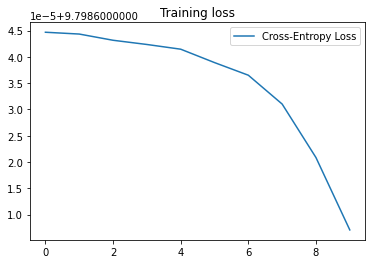

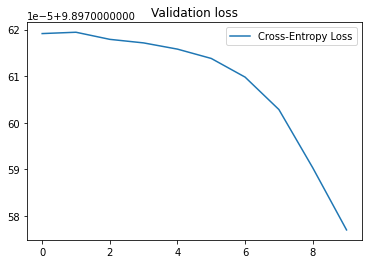

5.246081688774137e-231

LSTM model:
Epoch 1 of 10


100%|██████████| 10/10 [00:58<00:00,  5.84s/it]


        Train Loss: 9.798644514083863 Validation Loss: 9.897620582580567 Validation BLEU score: 0
Epoch 2 of 10


100%|██████████| 10/10 [00:57<00:00,  5.77s/it]


        Train Loss: 9.798644046783448 Validation Loss: 9.897620582580567 Validation BLEU score: 4.7086799100740044e-231
Epoch 3 of 10


100%|██████████| 10/10 [00:57<00:00,  5.78s/it]


        Train Loss: 9.798643579483032 Validation Loss: 9.897620010375977 Validation BLEU score: 4.7086799100740044e-231
Epoch 4 of 10


100%|██████████| 10/10 [00:55<00:00,  5.57s/it]


        Train Loss: 9.798642816543579 Validation Loss: 9.897619533538819 Validation BLEU score: 5.264243607255987e-231
Epoch 5 of 10


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


        Train Loss: 9.798642368316651 Validation Loss: 9.897618103027344 Validation BLEU score: 4.084300218963095e-231
Epoch 6 of 10


100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


        Train Loss: 9.798641567230225 Validation Loss: 9.897618007659911 Validation BLEU score: 5.264243607255987e-231
Epoch 7 of 10


100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


        Train Loss: 9.79864073753357 Validation Loss: 9.897616100311279 Validation BLEU score: 3.5905033738610204e-231
Epoch 8 of 10


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


        Train Loss: 9.79863953590393 Validation Loss: 9.897613048553467 Validation BLEU score: 3.5905033738610204e-231
Epoch 9 of 10


100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


        Train Loss: 9.79863492012024 Validation Loss: 9.897604370117188 Validation BLEU score: 3.5905033738610204e-231
Epoch 10 of 10


100%|██████████| 10/10 [00:55<00:00,  5.53s/it]

        Train Loss: 9.798612079620362 Validation Loss: 9.89755859375 Validation BLEU score: 3.5905033738610204e-231


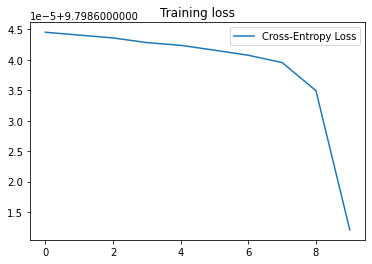

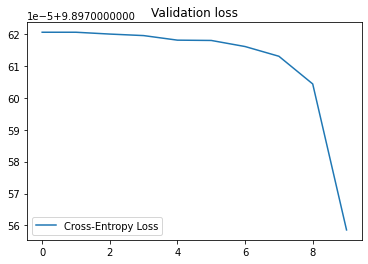

3.5905033738610204e-231

GRU model:
Epoch 1 of 10


100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


        Train Loss: 9.798643856048583 Validation Loss: 9.897619342803955 Validation BLEU score: 6.720628411503338e-232
Epoch 2 of 10


100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


        Train Loss: 9.798642892837524 Validation Loss: 9.897619152069092 Validation BLEU score: 6.720628411503338e-232
Epoch 3 of 10


100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


        Train Loss: 9.798642091751098 Validation Loss: 9.897618293762207 Validation BLEU score: 8.614911585158347e-232
Epoch 4 of 10


100%|██████████| 10/10 [00:52<00:00,  5.29s/it]


        Train Loss: 9.798640527725219 Validation Loss: 9.89761724472046 Validation BLEU score: 6.720628411503338e-232
Epoch 5 of 10


100%|██████████| 10/10 [00:53<00:00,  5.34s/it]


        Train Loss: 9.798639221191406 Validation Loss: 9.897613716125488 Validation BLEU score: 1.6159552844379352e-231
Epoch 6 of 10


100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


        Train Loss: 9.798636493682862 Validation Loss: 9.897609424591064 Validation BLEU score: 3.4377872738833774e-231
Epoch 7 of 10


100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


        Train Loss: 9.79863166809082 Validation Loss: 9.897600364685058 Validation BLEU score: 3.4377872738833774e-231
Epoch 8 of 10


100%|██████████| 10/10 [00:53<00:00,  5.30s/it]


        Train Loss: 9.798618001937866 Validation Loss: 9.897581100463867 Validation BLEU score: 8.67425185279243e-231
Epoch 9 of 10


100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


        Train Loss: 9.798585014343262 Validation Loss: 9.897531127929687 Validation BLEU score: 6.633776388912467e-231
Epoch 10 of 10


100%|██████████| 10/10 [00:53<00:00,  5.33s/it]

        Train Loss: 9.798511018753052 Validation Loss: 9.897426414489747 Validation BLEU score: 6.633776388912467e-231


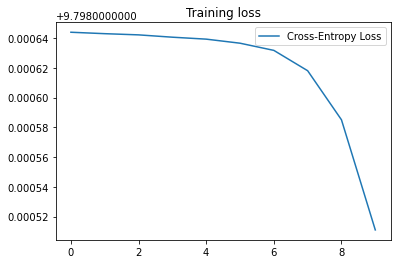

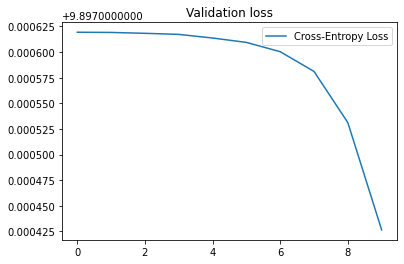

6.633776388912467e-231

The best model uses GRU cells.


In [81]:
#Training each GRU, LSTM, and RNN based models...
import matplotlib.pyplot as plt

print('\nRNN model:')
model1 = EncoderDecoder(input_vocab_size=len(source_vocab),target_vocab_size=len(target_vocab), embedding_size=10, cell_type = 'RNN', hidden_size=20, layers = 1)
_,_,b1 = model1.train(xen = x_train[:100], xes = y_train[:100], xen_test = x_test[:10], xes_test = y_test[:10], epochs=10, lr=0.0001, tf_ratio=0.3)
print(b1)
print('\nLSTM model:')
model2 = EncoderDecoder(input_vocab_size=len(source_vocab),target_vocab_size=len(target_vocab), embedding_size=10, cell_type = 'LSTM', hidden_size=20, layers = 1)
_,_,b2 = model2.train(xen = x_train[:100], xes = y_train[:100], xen_test = x_test[:10], xes_test = y_test[:10], epochs=10, lr=0.0001, tf_ratio=0.3)
print(b2)
print('\nGRU model:')
model3 = EncoderDecoder(input_vocab_size=len(source_vocab),target_vocab_size=len(target_vocab), embedding_size=10, cell_type = 'GRU', hidden_size=20, layers = 1)
_,_,b3 = model3.train(xen = x_train[:100], xes = y_train[:100], xen_test = x_test[:10], xes_test = y_test[:10], epochs=10, lr=0.0001, tf_ratio=0.3)
print(b3)

if b1 > b2 and b1 > b3:
    best_model = model1
elif b2 > b1 and b2 > b3:
    best_model = model2
else:
    best_model = model3
    
print('\nThe best model uses', best_model.Encoder.cell_type,'cells.')

***NOTE***
I only treained on fraction of the data for a few eps due to time constraints. 

## 4. Evaluation (20 points)
1. Calculate the BLEU scores of the best seq2seq model obtained from section 2&3 on the test set.
2. Select 20 test examples, For each example, print the translation result of your model along with the ground truth

### 4.1 Calculate the BLEU score on test set. (10 points)

In [88]:
x_testt = []
y_testt = []
for i in test_set:
    if len(i[0])>2 and len(i[1])>2:
        x_testt.append(i[0])
        y_testt.append(i[1])
b_av = 0
k = len(x_testt)#200
for i in range(k):#len(x_testt)):
    yp = best_model.forward([x_testt[i]], y_testt[i],0)
    #print(OneHot(torch.tensor([y_testt[i]]), len(target_vocab)).squeeze().shape,yp.shape)#OneHot(torch.tensor(y_testt[i]), len(target_vocab))
    ye_words = Hot_to_word(OneHot(torch.tensor([y_testt[i]]), len(target_vocab)),target_vocab)
    yp_words = Hot_to_word(yp.unsqueeze(0),target_vocab)
    #print(ye_words,yp_words)
    b = best_model.BLEU(yp_words,ye_words)
    b_av += b
print('Average BLEU score on test set =', b_av/k)

Average BLEU score on test set = 4.746194810385091e-231


### 4.2 Translate 20 test exmaples. (10 points)

In [85]:
for i in range(20):#len(x_testt)):
    x_words = Hot_to_word(OneHot(torch.tensor([x_testt[i]]), len(source_vocab)),source_vocab)
    yp = best_model.forward([x_testt[i]], y_testt[i],0)
    ye_words = Hot_to_word(OneHot(torch.tensor([y_testt[i]]), len(target_vocab)),target_vocab)
    yp_words = Hot_to_word(yp.unsqueeze(0),target_vocab)
    print('\n\n Sentence '+str(int(i+1))+':')
    print('\nInput in English:')
    print(''.join(str(j)+' ' for j in x_words))
    print('\nPredicted translation in Spanish:')
    print(''.join(str(j)+' ' for j in yp_words))
    print('\nGround Truth translation in Spanish:')
    print(''.join(str(j)+' ' for j in ye_words))



 Sentence 1:

Input in English:
mr rübig , as president - in - office , i can not give you an answer for the simple reason that the statement by the portuguese prime minister on behalf of the fourteen heads of state and government of the member states of the european union was adopted <unk> and not by him in his capacity as president - in - office of the council of the european union . 

Predicted translation in Spanish:
de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de 



 Sentence 9:

Input in English:
next session of un human rights commission 

Predicted translation in Spanish:
de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de 

Ground Truth translation in Spanish:
próxima sesión " derechos humanos " de la onu 


 Sentence 10:

Input in English:
if reforms are not got under way , we are in danger of eroding the economic basis of social policy , and a strong and competitive economy is now undoubtedly the most 



 Sentence 17:

Input in English:
they may have at least exploited some ambiguity in the legal and contractual framework in force . 

Predicted translation in Spanish:
de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de 

Ground Truth translation in Spanish:
es posible que , cuando menos , hayan <unk> una cierta ambigüedad del marco jurídico y <unk> en vigor . 


 Sentence 18:

Input in English:
though our proposal to withdraw political invitation